## Set up

### imports

In [1]:

import sys
import numpy as np
import keras
from sklearn.metrics import classification_report, accuracy_score
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
import pandas as pd
import gc
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
sys.path.append('../src')
from data.utils import load
from models.create_models import create_cnn_model, create_fcnn_model
from keras import backend as K


keras.utils.set_random_seed(42)

2024-09-05 10:21:55.711106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 10:21:55.744303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 10:21:55.752650: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 10:21:55.776884: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 10:21:57.308400: W tensorflow/compiler/tf2

### definitions

In [2]:
data_dir = "../data/"

# input image dimensions
img_rows, img_cols = 28, 28


PATH_MODELS = "../models/"
PATH_LOGS = "../logs/"
RESULTS_PATH = "../results/"

BATCH_SIZE = 128
EPOCHS = 1000

### Carregar dataset

In [3]:
# Load the data
X_train = load(data_dir + 'kmnist-train-imgs.npz')
X_test = load(data_dir + 'kmnist-test-imgs.npz')
y_train = load(data_dir + 'kmnist-train-labels.npz')
y_test = load(data_dir + 'kmnist-test-labels.npz')


if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('{} train samples, {} test samples'.format(len(X_train), len(X_test)))

# coleta dos valores unicos e das contagens
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

num_classes = len(unique_train) if list(unique_train) == list(unique_test) else None



# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 train samples, 10000 test samples


### Criar conjunto aumentado

In [4]:
# Crie o gerador de dados com data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

# Supomos que você tenha suas imagens de treino em x_train e labels em y_train
datagen.fit(X_train)

# Defina o número de amostras aumentadas que você deseja criar
num_augmented_samples = len(X_train) * 10  # por exemplo, 10 vezes o conjunto original

# Inicialize arrays para armazenar os dados aumentados
X_train_augmented = np.zeros((num_augmented_samples, *X_train.shape[1:]), dtype=np.float32)
y_train_augmented = np.zeros((num_augmented_samples, *y_train.shape[1:]), dtype=np.float32)

# Gere os dados aumentados
i = 0
for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size=BATCH_SIZE):
    if i >= num_augmented_samples:
        break
    batch_size_aux = x_batch.shape[0]
    X_train_augmented[i:i+batch_size_aux] = x_batch
    y_train_augmented[i:i+batch_size_aux] = y_batch
    i += batch_size_aux

## Analysis

In [5]:
print("Num class train: ", len(unique_train))
print("Num class test: ", len(unique_test))


print('### Treino ###')
for i in range(len(unique_train)): print(f'classe {unique_train[i]}: {counts_train[i]} observações')
print('\n### Teste ###')
for i in range(len(unique_test)): print(f'classe {unique_test[i]}: {counts_test[i]} observações')

Num class train:  10
Num class test:  10
### Treino ###
classe 0: 6000 observações
classe 1: 6000 observações
classe 2: 6000 observações
classe 3: 6000 observações
classe 4: 6000 observações
classe 5: 6000 observações
classe 6: 6000 observações
classe 7: 6000 observações
classe 8: 6000 observações
classe 9: 6000 observações

### Teste ###
classe 0: 1000 observações
classe 1: 1000 observações
classe 2: 1000 observações
classe 3: 1000 observações
classe 4: 1000 observações
classe 5: 1000 observações
classe 6: 1000 observações
classe 7: 1000 observações
classe 8: 1000 observações
classe 9: 1000 observações


## Classification

In [6]:
METRICS =[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.FalseNegatives(name='fn')
    ]

I0000 00:00:1725542654.928694 3984187 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725542655.043967 3984187 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725542655.046905 3984187 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725542655.051377 3984187 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

### CNN Benchmark

#### Normal

In [7]:
# callbacks do modelo benchmark
callbacks_benchmark = [
    ModelCheckpoint(PATH_MODELS + f'best_model_CNN_benchmark.keras', save_best_only=True, monitor='val_loss'),
    TensorBoard(log_dir=PATH_LOGS),
    CSVLogger(PATH_MODELS + f'training_log_CNN_benchmark.csv')
]

# limpa sessao do keras
keras.backend.clear_session()
gc.collect()

# cria modelo
model_benchmark = create_cnn_model(
    input_shape=input_shape,
    num_classes= num_classes,
    metrics= METRICS
)

# treina modelo
history_benchmark = model_benchmark.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=12,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks = callbacks_benchmark
          )

# realiza predicao
train_pred_proba = model_benchmark.predict(X_train)
test_pred_proba = model_benchmark.predict(X_test)

# salva predicao no treino
test_results_benchmark = pd.DataFrame({
    "y_test": y_test.argmax(axis=1),
    "y_test_pred": np.argmax(test_pred_proba, axis =1),
    "y_test_pred_proba": list(test_pred_proba)
    
})
test_results_benchmark.to_csv(RESULTS_PATH + 'test/cnn_benchmark_test_results.csv', index = False)

# salva predicao no teste
train_results_benchmark = pd.DataFrame({
    "y_train": y_train.argmax(axis=1),
    "y_train_pred": np.argmax(train_pred_proba, axis =1),
    "y_train_pred_proba": list(train_pred_proba)
})
train_results_benchmark.to_csv(RESULTS_PATH + 'train/cnn_benchmark_train_results.csv', index = False)

json.dump(history_benchmark.history, open(RESULTS_PATH + "history/benchmark_cnn_history.json", "w"))


/home/semcovici/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-05 10:24:15.704955: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2024-09-05 10:24:15.879207: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/12


I0000 00:00:1725542658.029782 3985886 service.cc:146] XLA service 0x7a14a000c170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725542658.029850 3985886 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-09-05 10:24:18.106560: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-05 10:24:18.301424: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  7/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1249 - auc: 0.5117 - fn: 512.0000 - fp: 0.0000e+00 - loss: 2.3040 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 4608.0000 - tp: 0.0000e+00  

I0000 00:00:1725542661.021999 3985886 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.1233 - auc: 0.5476 - fn: 30143.5918 - fp: 0.0000e+00 - loss: 2.2922 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 271292.3125 - tp: 0.0000e+00 - val_accuracy: 0.1686 - val_auc: 0.6450 - val_fn: 10000.0000 - val_fp: 0.0000e+00 - val_loss: 2.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 90000.0000 - val_tp: 0.0000e+00
Epoch 2/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1778 - auc: 0.6462 - fn: 30143.5918 - fp: 0.0000e+00 - loss: 2.2544 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 271292.3125 - tp: 0.0000e+00 - val_accuracy: 0.2550 - val_auc: 0.7155 - val_fn: 10000.0000 - val_fp: 0.0000e+00 - val_loss: 2.2363 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 90000.0000 - val_tp: 0.0000e+00
Epoch 3/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2548 - auc: 0.7184 - fn: 30143.5918 - fp: 0.0000e+00 - loss: 2.2071 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 27

2024-09-05 10:25:18.972593: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2024-09-05 10:25:19.111155: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 991us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


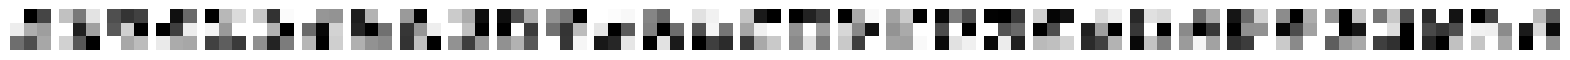

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Extraindo os pesos da primeira camada convolucional
filters, biases = model_benchmark.layers[0].get_weights()
n_filters = filters.shape[-1]

# Normalizando os filtros para a faixa [0, 1]
filters_min = filters.min()
filters_max = filters.max()
filters = (filters - filters_min) / (filters_max - filters_min)

# Visualizando os filtros
fig, axs = plt.subplots(1, n_filters, figsize=(20, 20))
for i in range(n_filters):
    f = filters[:, :, :, i]
    axs[i].imshow(f[:, :, 0], cmap='gray')
    axs[i].axis('off')

plt.show()


#### Com Data Augmentation

In [9]:
# callbacks do modelo benchmark
callbacks_benchmark_aug = [
    ModelCheckpoint(PATH_MODELS + f'best_model_CNN_aug_benchmark.keras', save_best_only=True, monitor='val_loss'),
    TensorBoard(log_dir=PATH_LOGS),
    CSVLogger(PATH_MODELS + f'training_log_CNN_aug_benchmark.csv')
]

# limpa sessao do keras
keras.backend.clear_session()
gc.collect()

# cria modelo
model_benchmark_aug = create_cnn_model(
    input_shape=input_shape,
    num_classes= num_classes,
    metrics= METRICS
)

# treina modelo
history_benchmark_aug = model_benchmark_aug.fit(X_train_augmented, y_train_augmented,
          batch_size=BATCH_SIZE,
          epochs=12,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks = callbacks_benchmark_aug
          )

# realiza predicao
train_pred_proba = model_benchmark_aug.predict(X_train)
test_pred_proba = model_benchmark_aug.predict(X_test)

# salva predicao no treino
test_results_benchmark_aug = pd.DataFrame({
    "y_test": y_test.argmax(axis=1),
    "y_test_pred": np.argmax(test_pred_proba, axis =1),
    "y_test_pred_proba": list(test_pred_proba)
    
})
test_results_benchmark_aug.to_csv(RESULTS_PATH + 'test/cnn_benchmark_aug_test_results.csv', index = False)

# salva predicao no teste
train_results_benchmark_aug = pd.DataFrame({
    "y_train": y_train.argmax(axis=1),
    "y_train_pred": np.argmax(train_pred_proba, axis =1),
    "y_train_pred_proba": list(train_pred_proba)
})
train_results_benchmark_aug.to_csv(RESULTS_PATH + 'train/cnn_benchmark_aug_train_results.csv', index = False)

json.dump(history_benchmark_aug.history, open(RESULTS_PATH + "history/benchmark_aug_cnn_history.json", "w"))


/home/semcovici/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-05 10:25:36.800729: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1881600000 exceeds 10% of free system memory.


Epoch 1/12
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - accuracy: 0.2008 - auc: 0.6659 - fn: 308275.6562 - fp: 161.5010 - loss: 2.2286 - precision: 0.9211 - recall: 0.0128 - tn: 2791278.0000 - tp: 1884.2921 - val_accuracy: 0.4910 - val_auc: 0.8069 - val_fn: 9971.0000 - val_fp: 2.0000 - val_loss: 1.8614 - val_precision: 0.9355 - val_recall: 0.0029 - val_tn: 89998.0000 - val_tp: 29.0000
Epoch 2/12
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - accuracy: 0.4373 - auc: 0.8260 - fn: 277098.5000 - fp: 4789.5864 - loss: 1.7452 - precision: 0.8457 - recall: 0.0583 - tn: 2696650.0000 - tp: 23061.4355 - val_accuracy: 0.5380 - val_auc: 0.8597 - val_fn: 7899.0000 - val_fp: 221.0000 - val_loss: 1.5138 - val_precision: 0.9048 - val_recall: 0.2101 - val_tn: 89779.0000 - val_tp: 2101.0000
Epoch 3/12
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 45s 9ms/step - accuracy: 0.5202 - auc: 0.8729 - fn: 224402.8125 - fp: 19779.4219 - loss: 1.4707 - precision: 0.7935 - recall: 0.2430 - tn: 2681660.0000 - tp: 75757.1250 - va

### CNN

#### Normal

In [10]:
# callbacks cnn
callbacks_cnn = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(PATH_MODELS + f'best_model_CNN.keras', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    TensorBoard(log_dir=PATH_LOGS),
    CSVLogger(PATH_MODELS + f'training_log_CNN.csv')
]

# limpa sessao do keras
keras.backend.clear_session()
gc.collect()

# cria modelo
model_cnn = create_cnn_model(
    input_shape=input_shape,
    num_classes= num_classes,
    metrics = METRICS
)

# treina modelo
history_cnn = model_cnn.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=callbacks_cnn
          )


# realiza predicao
train_pred_proba = model_cnn.predict(X_train)
test_pred_proba = model_cnn.predict(X_test)

# salva predicao no treino
test_results_cnn = pd.DataFrame({
    "y_test": y_test.argmax(axis=1),
    "y_test_pred": np.argmax(test_pred_proba, axis =1),
    "y_test_pred_proba": list(test_pred_proba)
    
})
test_results_cnn.to_csv(RESULTS_PATH + 'test/cnn_test_results.csv', index = False)

# salva predicao no teste
train_results_cnn = pd.DataFrame({
    "y_train": y_train.argmax(axis=1),
    "y_train_pred": np.argmax(train_pred_proba, axis =1),
    "y_train_pred_proba": list(train_pred_proba)
})
train_results_cnn.to_csv(RESULTS_PATH + 'train/cnn_train_results.csv', index = False)


json.dump(history_cnn.history, open(RESULTS_PATH + "history/cnn_history.json", "w"))

Epoch 1/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.1023 - auc: 0.7101 - fn: 34308.5898 - fp: 769.0000 - loss: 2.3037 - precision: 0.8836 - recall: 0.1884 - tn: 360523.3125 - tp: 5835.0000 - val_accuracy: 0.2417 - val_auc: 0.6698 - val_fn: 10000.0000 - val_fp: 0.0000e+00 - val_loss: 2.2634 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 90000.0000 - val_tp: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2130 - auc: 0.6576 - fn: 30143.5918 - fp: 0.0000e+00 - loss: 2.2409 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 271292.3125 - tp: 0.0000e+00 - val_accuracy: 0.3417 - val_auc: 0.7452 - val_fn: 10000.0000 - val_fp: 0.0000e+00 - val_loss: 2.2095 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 90000.0000 - val_tp: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3087 - auc: 0.7426 - fn: 30143.5918 - fp: 0.0000e+00 - loss: 2.16

#### Sem pooling

In [11]:
# callbacks cnn
callbacks_cnn_wo_poll = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(PATH_MODELS + f'best_model_CNN_without_polling.keras', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    TensorBoard(log_dir=PATH_LOGS),
    CSVLogger(PATH_MODELS + f'training_log_CNN_without_polling.csv')
]

# limpa sessao do keras
keras.backend.clear_session()
gc.collect()

# cria modelo
model_cnn_wo_poll = create_cnn_model(
    input_shape=input_shape,
    num_classes= num_classes,
    metrics = METRICS,
    polling = False
)

# treina modelo
history_cnn_wo_poll = model_cnn_wo_poll.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=callbacks_cnn_wo_poll
          )


# realiza predicao
train_pred_proba = model_cnn_wo_poll.predict(X_train)
test_pred_proba = model_cnn_wo_poll.predict(X_test)

# salva predicao no treino
test_results_cnn_wo_poll = pd.DataFrame({
    "y_test": y_test.argmax(axis=1),
    "y_test_pred": np.argmax(test_pred_proba, axis =1),
    "y_test_pred_proba": list(test_pred_proba)
    
})
test_results_cnn_wo_poll.to_csv(RESULTS_PATH + 'test/cnn_without_polling_test_results.csv', index = False)

# salva predicao no teste
train_results_cnn_wo_poll = pd.DataFrame({
    "y_train": y_train.argmax(axis=1),
    "y_train_pred": np.argmax(train_pred_proba, axis =1),
    "y_train_pred_proba": list(train_pred_proba)
})
train_results_cnn_wo_poll.to_csv(RESULTS_PATH + 'train/cnn_without_polling_train_results.csv', index = False)


json.dump(history_cnn_wo_poll.history, open(RESULTS_PATH + "history/cnn_without_polling_history.json", "w"))

Epoch 1/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.1855 - auc: 0.7956 - fn: 31604.5918 - fp: 648.0000 - loss: 2.2703 - precision: 0.9295 - recall: 0.2757 - tn: 360644.3125 - tp: 8539.0000 - val_accuracy: 0.3179 - val_auc: 0.7535 - val_fn: 10000.0000 - val_fp: 0.0000e+00 - val_loss: 2.1925 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 90000.0000 - val_tp: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3909 - auc: 0.7979 - fn: 30142.7852 - fp: 0.0000e+00 - loss: 2.0843 - precision: 0.2426 - recall: 1.4515e-05 - tn: 271292.3125 - tp: 0.8064 - val_accuracy: 0.4309 - val_auc: 0.8022 - val_fn: 10000.0000 - val_fp: 0.0000e+00 - val_loss: 1.9898 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 90000.0000 - val_tp: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5066 - auc: 0.8586 - fn: 29584.8574 - fp: 17.4745 - loss: 1.7847 - precis

#### Com data augmentation

In [12]:
# callbacks cnn
callbacks_cnn_aug = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(PATH_MODELS + f'best_model_CNN_aug.keras', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    TensorBoard(log_dir=PATH_LOGS),
    CSVLogger(PATH_MODELS + f'training_log_CNN_aug.csv')
]

# limpa sessao do keras
keras.backend.clear_session()
gc.collect()

# cria modelo
model_cnn_aug = create_cnn_model(
    input_shape=input_shape,
    num_classes= num_classes,
    metrics = METRICS
)

# treina modelo
history_cnn_aug = model_cnn_aug.fit(X_train_augmented, y_train_augmented,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=callbacks_cnn_aug
          )


# realiza predicao
train_pred_proba = model_cnn_aug.predict(X_train)
test_pred_proba = model_cnn_aug.predict(X_test)

# salva predicao no treino
test_results_cnn_aug = pd.DataFrame({
    "y_test": y_test.argmax(axis=1),
    "y_test_pred": np.argmax(test_pred_proba, axis =1),
    "y_test_pred_proba": list(test_pred_proba)
    
})
test_results_cnn_aug.to_csv(RESULTS_PATH + 'test/cnn_aug_test_results.csv', index = False)

# salva predicao no teste
train_results_cnn_aug = pd.DataFrame({
    "y_train": y_train.argmax(axis=1),
    "y_train_pred": np.argmax(train_pred_proba, axis =1),
    "y_train_pred_proba": list(train_pred_proba)
})
train_results_cnn_aug.to_csv(RESULTS_PATH + 'train/cnn_aug_train_results.csv', index = False)


json.dump(history_cnn_aug.history, open(RESULTS_PATH + "history/cnn_aug_history.json", "w"))



Epoch 1/1000
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 61s 10ms/step - accuracy: 0.2238 - auc: 0.7011 - fn: 301037.4375 - fp: 729.5611 - loss: 2.1932 - precision: 0.9268 - recall: 0.0598 - tn: 2790710.0000 - tp: 9122.5176 - val_accuracy: 0.4709 - val_auc: 0.8130 - val_fn: 9624.0000 - val_fp: 14.0000 - val_loss: 1.7720 - val_precision: 0.9641 - val_recall: 0.0376 - val_tn: 89986.0000 - val_tp: 376.0000 - learning_rate: 0.0010
Epoch 2/1000
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - accuracy: 0.4577 - auc: 0.8393 - fn: 260617.8906 - fp: 9234.5479 - loss: 1.6587 - precision: 0.8190 - recall: 0.1134 - tn: 2692205.0000 - tp: 39542.0469 - val_accuracy: 0.5365 - val_auc: 0.8638 - val_fn: 7627.0000 - val_fp: 296.0000 - val_loss: 1.4945 - val_precision: 0.8891 - val_recall: 0.2373 - val_tn: 89704.0000 - val_tp: 2373.0000 - learning_rate: 0.0010
Epoch 3/1000
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - accuracy: 0.5292 - auc: 0.8790 - fn: 217849.4219 - fp: 21894.0020 - loss: 1.4370 - precision: 0.7903 -

### Fully Connected

#### Normal

In [13]:
# callbacks cnn
callbacks_fcnn = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(PATH_MODELS + f'best_model_fcnn.keras', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    TensorBoard(log_dir=PATH_LOGS),
    CSVLogger(PATH_MODELS + f'training_log_fcnn.csv')
]

# limpa sessao do keras
keras.backend.clear_session()

# cria modelo
model_fcnn = create_fcnn_model(
    input_shape=input_shape,
    num_classes= num_classes,
    metrics = METRICS
)

# treina modelo
history_fcnn = model_fcnn.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=callbacks_fcnn
          )


# realiza predicao
train_pred_proba = model_fcnn.predict(X_train)
test_pred_proba = model_fcnn.predict(X_test)

# salva predicao no treino
test_results_fcnn = pd.DataFrame({
    "y_test": y_test.argmax(axis=1),
    "y_test_pred": np.argmax(test_pred_proba, axis =1),
    "y_test_pred_proba": list(test_pred_proba)
    
})
test_results_fcnn.to_csv(RESULTS_PATH + 'test/fcnn_test_results.csv', index = False)


# salva predicao no teste
train_results_fcnn = pd.DataFrame({
    "y_train": y_train.argmax(axis=1),
    "y_train_pred": np.argmax(train_pred_proba, axis =1),
    "y_train_pred_proba": list(train_pred_proba)
})
train_results_fcnn.to_csv(RESULTS_PATH + 'train/fcnn_train_results.csv', index = False)


json.dump(history_fcnn.history, open(RESULTS_PATH + "history/fcnn_history.json", "w"))

/home/semcovici/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/semcovici/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - accuracy: 0.1027 - auc: 0.7439 - fn: 31024.2324 - fp: 1257.7234 - loss: 2.5515 - precision: 0.8797 - recall: 0.2936 - tn: 360034.5938 - tp: 9119.3594 - val_accuracy: 0.1213 - val_auc: 0.5355 - val_fn: 10000.0000 - val_fp: 0.0000e+00 - val_loss: 2.2948 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 90000.0000 - val_tp: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1110 - auc: 0.5214 - fn: 30072.0645 - fp: 378.0745 - loss: 2.4863 - precision: 0.1634 - recall: 0.0025 - tn: 270914.2500 - tp: 71.5277 - val_accuracy: 0.1371 - val_auc: 0.5627 - val_fn: 10000.0000 - val_fp: 0.0000e+00 - val_loss: 2.2773 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 90000.0000 - val_tp: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1123 - auc: 0.5308 - fn: 30089.3594 - fp: 236.2766 - loss: 2.4430 - precision: 

#### com data augmentation

In [14]:
# callbacks cnn
callbacks_fcnn_aug = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(PATH_MODELS + f'best_model_fcnn_aug.keras', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    TensorBoard(log_dir=PATH_LOGS),
    CSVLogger(PATH_MODELS + f'training_log_fcnn_aug.csv')
]

# limpa sessao do keras
keras.backend.clear_session()

# cria modelo
model_fcnn_aug = create_fcnn_model(
    input_shape=input_shape,
    num_classes= num_classes,
    metrics = METRICS
)

# treina modelo
history_fcnn_aug = model_fcnn_aug.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=callbacks_fcnn_aug
          )


# realiza predicao
train_pred_proba = model_fcnn_aug.predict(X_train)
test_pred_proba = model_fcnn_aug.predict(X_test)

# salva predicao no treino
test_results_fcnn_aug = pd.DataFrame({
    "y_test": y_test.argmax(axis=1),
    "y_test_pred": np.argmax(test_pred_proba, axis =1),
    "y_test_pred_proba": list(test_pred_proba)
    
})
test_results_fcnn_aug.to_csv(RESULTS_PATH + 'test/fcnn_aug_test_results.csv', index = False)


# salva predicao no teste
train_results_fcnn_aug = pd.DataFrame({
    "y_train": y_train.argmax(axis=1),
    "y_train_pred": np.argmax(train_pred_proba, axis =1),
    "y_train_pred_proba": list(train_pred_proba)
})
train_results_fcnn_aug.to_csv(RESULTS_PATH + 'train/fcnn_aug_train_results.csv', index = False)


json.dump(history_fcnn_aug.history, open(RESULTS_PATH + "history/fcnn_aug_history.json", "w"))

Epoch 1/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.0925 - auc: 0.7160 - fn: 32185.9434 - fp: 1762.6873 - loss: 2.6066 - precision: 0.8202 - recall: 0.2562 - tn: 359529.6250 - tp: 7957.6489 - val_accuracy: 0.1029 - val_auc: 0.5106 - val_fn: 10000.0000 - val_fp: 0.0000e+00 - val_loss: 2.3119 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 90000.0000 - val_tp: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1056 - auc: 0.5077 - fn: 30093.2363 - fp: 452.7404 - loss: 2.5244 - precision: 0.1104 - recall: 0.0018 - tn: 270839.5938 - tp: 50.3553 - val_accuracy: 0.1294 - val_auc: 0.5433 - val_fn: 10000.0000 - val_fp: 0.0000e+00 - val_loss: 2.2882 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 90000.0000 - val_tp: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1117 - auc: 0.5188 - fn: 30094.8945 - fp: 296.7021 - loss: 2.4709 - precision: 